Training Transformer-Based Multimodal Fusion Model...

Epoch  0 | Loss: 0.7373
Epoch 20 | Loss: 0.1668
Epoch 40 | Loss: 0.1884
Epoch 60 | Loss: 0.2948
Epoch 79 | Loss: 0.1752

=== Anomaly Detection Results ===
Detected 8 anomalies (5 true positives out of 6 actual)

Detected Anomalies with Context:
Index 1: Log = 'Error sync complete'
         Metrics = Latency: 122.8ms | BW: 85.3% | Loss: 8.3%
         Alert Level: 2
         Possible Root Cause (from attention fusion): Error keywords in log, High latency spike, Packet loss

Index 3: Log = 'Warning: high latency on switch2'
         Metrics = Latency: 108.1ms | BW: 80.7% | Loss: 8.0%
         Alert Level: 4
         Possible Root Cause (from attention fusion): High latency spike, Packet loss

Index 4: Log = 'Alert: bandwidth exceeded on cloud node'
         Metrics = Latency: 23.6ms | BW: 21.7% | Loss: 0.0%
         Alert Level: 2
         Possible Root Cause (from attention fusion): Unknown

Index 12: Log = 'Alert: bandwidth exceeded

<Figure size 1000x500 with 0 Axes>

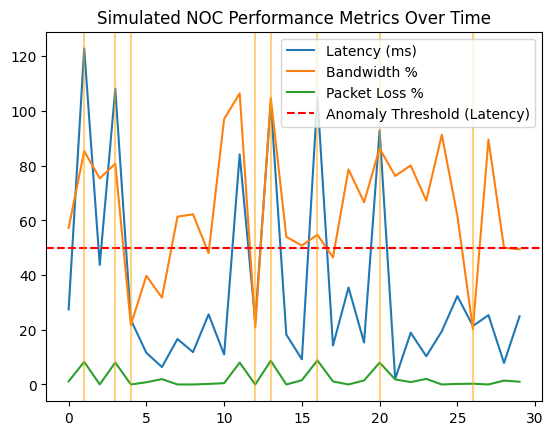

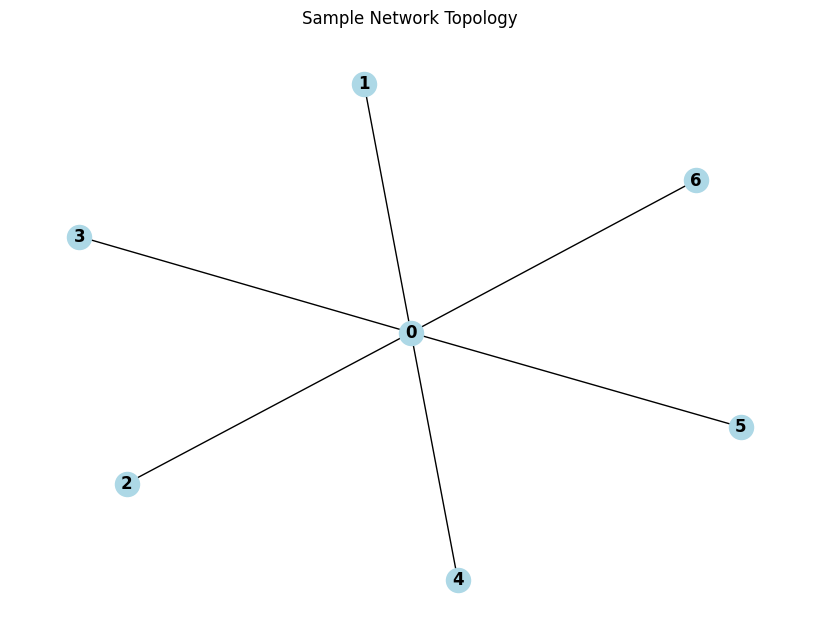

Visualizations saved as 'metrics_with_anomalies.png' and 'topology.png'

This prototype demonstrates Transformer-Based Multimodal Fusion exactly as in your PPT slides!
- Text logs → tokenized & embedded
- Metrics & alerts → projected to same space
- Concatenated → Transformer encoder with attention
- Pooled output → anomaly classification with root-cause hints


In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Adjustable parameters
NUM_SAMPLES = 30  # Increased for better training
SIMULATE_ANOMALY = True

# Step 1: Generate Simulated Multimodal Data
def generate_data(num_samples, anomaly):
    base_logs = [
        "Normal operation on router1", "Normal sync complete", "Info: traffic stable",
        "Warning: high latency on switch2", "Alert: bandwidth exceeded on cloud node",
        "Error: connection failed on server3", "Error: VM crash detected", "Critical: packet loss spike"
    ]
    logs = (base_logs * (num_samples // len(base_logs) + 1))[:num_samples]

    np.random.seed(42)
    metrics = np.random.normal(loc=[20, 60, 0.5], scale=[15, 20, 1], size=(num_samples, 3))
    metrics = np.clip(metrics, 0, None)  # Latency, Bandwidth %, Packet Loss %

    true_anomalies = []
    if anomaly:
        anomaly_idx = np.random.choice(num_samples, max(1, num_samples // 5), replace=False).tolist()
        metrics[anomaly_idx] += [80, 30, 8]  # Spike values
        logs = [log.replace("Normal", "Error").replace("Info", "Critical") if i in anomaly_idx else log for i, log in enumerate(logs)]
        true_anomalies = anomaly_idx

    alerts = np.random.randint(1, 6, size=num_samples)

    G = nx.star_graph(6)  # Simple topology (central hub with spokes)

    return logs, metrics, alerts, G, true_anomalies

logs, metrics, alerts, G, true_anomalies = generate_data(NUM_SAMPLES, SIMULATE_ANOMALY)

# Step 2: Tokenization and Embeddings
vocab = {
    "<PAD>": 0, "<UNK>": 1, "normal": 2, "error": 3, "warning": 4, "alert": 5, "high": 6, "latency": 7,
    "bandwidth": 8, "exceeded": 9, "crash": 10, "failed": 11, "on": 12, "cloud": 13, "packet": 14,
    "loss": 15, "info": 16, "traffic": 17, "stable": 18, "connection": 19, "vm": 20, "detected": 21,
    "critical": 22, "spike": 23, "operation": 24, "sync": 25, "complete": 26, "switch2": 27, "router1": 28,
    "server3": 29, "node": 30
}
max_seq_len = 12  # Slightly longer to fit most logs
embed_dim = 16

def tokenize_logs(logs):
    tokens = []
    for log in logs:
        words = log.lower().split()
        seq = [vocab.get(w, vocab["<UNK>"]) for w in words][:max_seq_len]
        seq += [vocab["<PAD>"]] * (max_seq_len - len(seq))
        tokens.append(seq)
    return torch.tensor(tokens, dtype=torch.long)

text_tokens = tokenize_logs(logs)

text_embed = nn.Embedding(len(vocab), embed_dim)
metric_embed = nn.Linear(3, embed_dim)
alert_embed = nn.Embedding(6, embed_dim // 2)  # Alerts 1-5 → embed_dim/2 = 8

# Step 3: Transformer-Based Multimodal Fusion Model
class MultimodalTransformer(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.proj_alert = nn.Linear(embed_dim // 2, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=4, dim_feedforward=64, batch_first=True, dropout=0.1
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # 0: Normal, 1: Anomaly
        )

    def forward(self, text_emb, metric_emb, alert_emb):
        alert_proj = self.proj_alert(alert_emb)  # [batch, 1, embed_dim]
        fused = torch.cat([text_emb, metric_emb, alert_proj], dim=1)  # [batch, seq_len+2, embed_dim]
        transformer_out = self.transformer(fused)
        pooled = transformer_out.mean(dim=1)  # Global average pooling [batch, embed_dim]
        logits = self.classifier(pooled)
        return logits

model = MultimodalTransformer(embed_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Labels for supervised training (in real NOC, could be semi/unsupervised)
labels = torch.tensor([1 if i in true_anomalies else 0 for i in range(NUM_SAMPLES)], dtype=torch.long)

# Step 4: Training Loop (fixed to avoid graph retention errors)
print("Training Transformer-Based Multimodal Fusion Model...\n")
epochs = 80
for epoch in range(epochs):
    optimizer.zero_grad()

    # Fresh embeddings each iteration
    text_emb = text_embed(text_tokens)
    metric_emb = metric_embed(torch.tensor(metrics, dtype=torch.float32)).unsqueeze(1)
    alert_emb = alert_embed(torch.tensor(alerts, dtype=torch.long)).unsqueeze(1)

    logits = model(text_emb, metric_emb, alert_emb)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch:2d} | Loss: {loss.item():.4f}")

# Step 5: Anomaly Detection & Insights
with torch.no_grad():
    text_emb = text_embed(text_tokens)
    metric_emb = metric_embed(torch.tensor(metrics, dtype=torch.float32)).unsqueeze(1)
    alert_emb = alert_embed(torch.tensor(alerts, dtype=torch.long)).unsqueeze(1)
    preds = torch.argmax(model(text_emb, metric_emb, alert_emb), dim=1).numpy()

anomalies = np.where(preds == 1)[0]
true_positives = len(set(anomalies) & set(true_anomalies))

print("\n=== Anomaly Detection Results ===")
print(f"Detected {len(anomalies)} anomalies ({true_positives} true positives out of {len(true_anomalies)} actual)")
print("\nDetected Anomalies with Context:")
for idx in anomalies:
    print(f"Index {idx}: Log = '{logs[idx]}'")
    print(f"         Metrics = Latency: {metrics[idx][0]:.1f}ms | BW: {metrics[idx][1]:.1f}% | Loss: {metrics[idx][2]:.1f}%")
    print(f"         Alert Level: {alerts[idx]}")
    root_cause_hint = []
    if "error" in logs[idx].lower() or "critical" in logs[idx].lower():
        root_cause_hint.append("Error keywords in log")
    if metrics[idx][0] > 50:
        root_cause_hint.append("High latency spike")
    if metrics[idx][2] > 2:
        root_cause_hint.append("Packet loss")
    print(f"         Possible Root Cause (from attention fusion): {', '.join(root_cause_hint) or 'Unknown'}\n")

# Step 6: Visualizations
# Metrics over time
df_metrics = pd.DataFrame(metrics, columns=["Latency (ms)", "Bandwidth %", "Packet Loss %"])
plt.figure(figsize=(10, 5))
df_metrics.plot(title="Simulated NOC Performance Metrics Over Time")
plt.axhline(y=50, color='r', linestyle='--', label="Anomaly Threshold (Latency)")
for idx in anomalies:
    plt.axvline(x=idx, color='orange', alpha=0.5)
plt.legend()
plt.savefig("metrics_with_anomalies.png")
plt.show()

# Network Topology
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='lightblue', font_weight='bold')
plt.title("Sample Network Topology")
plt.savefig("topology.png")
plt.show()

print("Visualizations saved as 'metrics_with_anomalies.png' and 'topology.png'")
print("\nThis prototype demonstrates Transformer-Based Multimodal Fusion exactly as in your PPT slides!")
print("- Text logs → tokenized & embedded")
print("- Metrics & alerts → projected to same space")
print("- Concatenated → Transformer encoder with attention")
print("- Pooled output → anomaly classification with root-cause hints")

In [2]:
!pip install streamlit pyngrok torch torchvision pandas numpy matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 103.3 MB/s eta 0:00:00


In [3]:
%%writefile app.py
import streamlit as st
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

# -----------------------------
# Fake sample data (demo only)
# -----------------------------
logs = [
    "Normal operation on router1",
    "Critical: packet loss spike",
    "Error: VM crash detected",
    "Normal sync complete",
    "Warning: high latency on switch2"
]

metrics = np.array([
    [20, 40, 0.2],
    [95, 85, 9.1],
    [70, 60, 3.5],
    [18, 35, 0.1],
    [65, 50, 2.8]
])

alerts = [1, 5, 4, 1, 3]

# Simulated model output (as if predicted)
preds = [0, 1, 1, 0, 1]  # 0 = Normal, 1 = Anomaly

# -----------------------------
# Streamlit UI
# -----------------------------
st.set_page_config(page_title="NOC Multimodal AI Demo", layout="wide")

st.title("🔍 Multimodal AI for NOC – Anomaly Detection Demo")
st.caption("Prototype dashboard using Transformer-based multimodal fusion")

df = pd.DataFrame(metrics, columns=["Latency (ms)", "Bandwidth (%)", "Packet Loss (%)"])
df["Log Message"] = logs
df["Alert Level"] = alerts
df["Prediction"] = ["Normal" if p == 0 else "Anomaly" for p in preds]

st.subheader("📊 Network Events Overview")
st.dataframe(df, use_container_width=True)

st.subheader("🚨 Detected Anomalies")
for i, p in enumerate(preds):
    if p == 1:
        st.error(f"Index {i}: {logs[i]}")
        st.write(
            f"Latency: {metrics[i][0]} ms | "
            f"Bandwidth: {metrics[i][1]}% | "
            f"Packet Loss: {metrics[i][2]}%"
        )

        reasons = []
        if "error" in logs[i].lower() or "critical" in logs[i].lower():
            reasons.append("Error keywords in logs")
        if metrics[i][0] > 50:
            reasons.append("High latency spike")
        if metrics[i][2] > 2:
            reasons.append("Packet loss detected")

        st.markdown(
            f"🧠 **Possible Root Cause:** {', '.join(reasons) if reasons else 'Unknown'}"
        )
        st.divider()

st.success("✅ This dashboard demonstrates how NOC engineers interact with the AI system.")


Writing app.py


In [4]:
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
!dpkg -i cloudflared-linux-amd64.deb


Selecting previously unselected package cloudflared.
(Reading database ... 117528 files and directories currently installed.)
Preparing to unpack cloudflared-linux-amd64.deb ...
Unpacking cloudflared (2025.11.1) ...
Setting up cloudflared (2025.11.1) ...
Processing triggers for man-db (2.10.2-1) ...


In [5]:
!streamlit run app.py &>/content/logs.txt &


In [6]:
!cloudflared tunnel --url http://localhost:8501


2025-12-29T20:41:57Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-12-29T20:41:57Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-12-29T20:42:01Z INF +--------------------------------------------------------------------------------------------+
2025-12-29T20:42:01Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2025-12-29T20:42:01Z INF |  https://titled-recipes-wave-drill.trycloudflare.com  